In [ ]:
from google.colab import drive
import numpy as np
drive.mount('/content/drive')
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

Mounted at /content/drive


In [ ]:
import pandas as pd
import os

# Load the Policy Metadata file
csv_file = 'directory of policy meta data file'

# Create a dictionary to map ID to state and action year
id_to_state_and_year = dict(zip(metadata['ID'].astype(str), zip(metadata['State / Jurisdiction'], metadata['Action_Year'])))

# Function to match txt file names with state and action year
def get_state_and_year_for_file(file_name, id_to_state_and_year):
    # Handle cases with letters in file names (e.g., 11a, 11b)
    base_file_name = ''.join([char for char in file_name if char.isdigit()])
    return id_to_state_and_year.get(base_file_name)

text_files_directory = "Directory containing the text files"
# Create a DataFrame to store file names, their states, and action years
file_state_year_data = []
for file_name in os.listdir(text_files_directory):
    if file_name.endswith('.txt'):
        state_year_info = get_state_and_year_for_file(file_name.split('.')[0], id_to_state_and_year)
        if state_year_info:
            state, action_year = state_year_info
            file_state_year_data.append({'File Name': file_name, 'State': state, 'Action Year': action_year})

# Convert to DataFrame
file_state_df = pd.DataFrame(file_state_year_data)
file_state_df['Action Year']=file_state_df['Action Year'].astype("int")

print(file_state_df)


    File Name          State  Action Year
0       3.txt         Alaska         2016
1       4.txt         Alaska         2018
2       7.txt       Arkansas         2017
3       8.txt       Arkansas         2015
4      10.txt        Arizona         2021
..        ...            ...          ...
151   147.txt      Wisconsin            0
152   149.txt  West Virginia            0
153    62.txt       Michigan         1987
154    40.txt        Indiana            0
155    87.txt         Nevada            0

[156 rows x 3 columns]


In [ ]:
# Preprocessing
import nltk
import re
from collections import Counter
from nltk.corpus import stopwords
import string
nltk.download('stopwords')
class TextProcessor:
    def __init__(self, input_corpus: list):
        self.processed_corpus = input_corpus

    def remove_digits_and_punctuation(self):
        regex_pattern = re.compile(r'[0-9]+|[^\w\s]')
        self.processed_corpus = [regex_pattern.sub(" ", row) for row in self.processed_corpus]

    def to_lowercase(self):
        self.processed_corpus = [row.lower() for row in self.processed_corpus]

    def remove_stop_words(self):
        stops = set(stopwords.words('english')) - {
            "shan't", "couldn't", "against", "shouldn't", "can't",
            "needn't", "should've", "not", "mustn't", "will"
        }
        stops.update(string.ascii_lowercase)
        stops.update(['ii', 'iii', 'iv'])
        self.processed_corpus = [
            " ".join([token for token in row.split() if token not in stops])
            for row in self.processed_corpus
        ]

    def remove_common_words(self):
        counter = Counter(" ".join(self.processed_corpus).split())
        most_common = set(word for word, count in counter.most_common(10))
        self.processed_corpus = [
            " ".join(token for token in row.split() if token not in most_common)
            for row in self.processed_corpus
        ]

    def process(self):
        self.remove_digits_and_punctuation()
        self.to_lowercase()
        self.remove_stop_words()
        self.remove_common_words()
        return self.processed_corpus

def read_text_files(directory):
    file_contents = {}
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            file_path = os.path.join(directory, filename)
            try:
                with open(file_path, 'r', encoding='utf-8') as file:
                    file_contents[filename] = file.read()
            except UnicodeDecodeError:
                try:
                    with open(file_path, 'r', encoding='ISO-8859-1') as file:
                        file_contents[filename] = file.read()
                except Exception as e:
                    print(f"Failed to read {filename}: {e}")
    return file_contents
# Load and preprocess the text files
file_directory = "Directory containing the text files"
file_contents = read_text_files(file_directory)
text_processor = TextProcessor(list(file_contents.values()))
preprocessed_texts = text_processor.process()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
file_to_state = dict(zip(file_state_df['File Name'], file_state_df['State']))
file_to_year_map = dict(zip(file_state_df['File Name'], file_state_df['Action Year']))
file_to_state_map = dict(zip(file_state_df['File Name'], file_state_df['State']))

In [ ]:
!pip install sentence-transformers

In [ ]:
!pip install gensim

In [ ]:
!pip install fasttext

In [ ]:
import fasttext
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')

'cc.en.300.bin'

In [ ]:
import zipfile
from gensim.scripts.glove2word2vec import glove2word2vec

glove_zip_path = '/content/drive/MyDrive/Policy_comparison/glove.6B.zip'
glove_folder = '/content/glove.6B'
with zipfile.ZipFile(glove_zip_path, 'r') as zip_ref:
    zip_ref.extractall(glove_folder)
glove_input_file = os.path.join(glove_folder, 'glove.6B.300d.txt')
word2vec_output_file = os.path.join(glove_folder, 'glove.6B.300d.word2vec.txt')
glove2word2vec(glove_input_file, word2vec_output_file)

<ipython-input-20-80b4c3d88f92>:10: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


(400001, 300)

In [ ]:
from collections import defaultdict
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel
import torch
from gensim.models import LdaMulticore
from gensim.models import KeyedVectors
from gensim.corpora import Dictionary
from nltk.tokenize import word_tokenize
import fasttext


def model_1(preprocessed_texts,n=10, top = True):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, lowercase=False, stop_words=None)
    tfidf = tfidf_vectorizer.fit_transform(preprocessed_texts)
    nmf = NMF(n_components=10, random_state=42)
    nmf_features = nmf.fit_transform(tfidf)
    similarity_matrix = cosine_similarity(nmf_features)
    similarity_scores = {}
    total_texts = len(preprocessed_texts)
    for i in range(total_texts):
        for j in range(i + 1, total_texts):
            if file_to_state[list(file_contents.keys())[i]] != file_to_state[list(file_contents.keys())[j]]:
                similarity_scores[(i, j)] = similarity_matrix[i, j]
    top_pairs = sorted(similarity_scores.items(), key=lambda x: x[1], reverse=top)[:n]
    return top_pairs

def model_2(preprocessed_texts,n=10, top = True):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), lowercase=False, stop_words=None, max_df=0.95, min_df=2)
    tfidf = tfidf_vectorizer.fit_transform(preprocessed_texts)
    nmf = NMF(n_components=10, random_state=42)
    nmf_features = nmf.fit_transform(tfidf)
    similarity_matrix = cosine_similarity(nmf_features)
    similarity_scores = {}
    total_texts = len(preprocessed_texts)
    for i in range(total_texts):
        for j in range(i + 1, total_texts):
            if file_to_state[list(file_contents.keys())[i]] != file_to_state[list(file_contents.keys())[j]]:
                similarity_scores[(i, j)] = similarity_matrix[i, j]
    top_pairs = sorted(similarity_scores.items(), key=lambda x: x[1], reverse=top)[:n]
    return top_pairs


def model_3(preprocessed_texts, n=10, top = True):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings = model.encode(preprocessed_texts, convert_to_tensor=False)
    pca = PCA(n_components=10)
    reduced_embeddings = pca.fit_transform(embeddings)
    similarity_matrix = cosine_similarity(reduced_embeddings)
    similarity_scores = {}
    total_texts = len(preprocessed_texts)
    for i in range(total_texts):
        for j in range(i + 1, total_texts):
            if file_to_state[list(file_contents.keys())[i]] != file_to_state[list(file_contents.keys())[j]]:
                similarity_scores[(i, j)] = similarity_matrix[i, j]
    top_pairs = sorted(similarity_scores.items(), key=lambda x: x[1], reverse=top)[:n]
    return top_pairs

def model_4(preprocessed_texts, n=10, top = True):
    model = fasttext.load_model('cc.en.300.bin')
    doc_embeddings = np.zeros((len(preprocessed_texts), 300))
    for i, doc in enumerate(preprocessed_texts):
        tokens = doc.split()
        doc_embeddings[i] = model.get_sentence_vector(' '.join(tokens))
    similarity_matrix = cosine_similarity(doc_embeddings)
    similarity_scores = {}
    for i in range(len(preprocessed_texts)):
        for j in range(i + 1, len(preprocessed_texts)):
            if file_to_state[list(file_contents.keys())[i]] != file_to_state[list(file_contents.keys())[j]]:
                similarity_scores[(i, j)] = similarity_matrix[i, j]
    top_pairs = sorted(similarity_scores.items(), key=lambda x: x[1], reverse=top)[:n]
    return top_pairs

def model_5(preprocessed_texts,n=10, top = True):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    def get_bert_embedding(text, tokenizer, model):
        inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512, padding=True)
        outputs = model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()
    bert_embeddings = [get_bert_embedding(doc, tokenizer, model) for doc in preprocessed_texts]
    similarity_matrix = cosine_similarity(bert_embeddings)
    similarity_scores = {}
    total_texts = len(preprocessed_texts)
    for i in range(total_texts):
        for j in range(i + 1, total_texts):
            if file_to_state[list(file_contents.keys())[i]] != file_to_state[list(file_contents.keys())[j]]:
                similarity_scores[(i, j)] = similarity_matrix[i, j]
    top_pairs = sorted(similarity_scores.items(), key=lambda x: x[1], reverse=top)[:n]
    return top_pairs

def model_6(preprocessed_texts, n=10, top = True):
    glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)
    doc_embeddings = np.zeros((len(preprocessed_texts), 300))
    for i, doc in enumerate(preprocessed_texts):
        tokens = doc.split()
        embeddings = [glove_model[word] for word in tokens if word in glove_model]
        if embeddings:
            doc_embeddings[i] = np.mean(embeddings, axis=0)
    pca = PCA(n_components=10)
    reduced_doc_embeddings = pca.fit_transform(doc_embeddings)
    similarity_matrix = cosine_similarity(reduced_doc_embeddings)
    similarity_scores = {}
    for i in range(len(preprocessed_texts)):
        for j in range(i + 1, len(preprocessed_texts)):
            if file_to_state[list(file_contents.keys())[i]] != file_to_state[list(file_contents.keys())[j]]:
                similarity_scores[(i, j)] = similarity_matrix[i, j]
    top_pairs = sorted(similarity_scores.items(), key=lambda x: x[1], reverse=top)[:n]
    return [(pair[0], pair[1]) for pair in top_pairs]

Top 20

In [ ]:
def ensemble_models(preprocessed_texts, file_to_state, n, top = True):
    top_pairs = defaultdict(lambda: {'count': 0, 'models': []})
    file_names = list(file_to_state.keys())

    model_functions = [model_1, model_2, model_3, model_4, model_5, model_6]
    model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6']

    for model_func, model_name in zip(model_functions, model_names):
        top_indices = model_func(preprocessed_texts, n)
        for (i, j), _ in top_indices:
            filenames = (file_names[i], file_names[j])
            top_pairs[filenames]['count'] += 1
            top_pairs[filenames]['models'].append(model_name)
    common_pairs_with_counts = [
        (pair, info['count'], info['models'])
        for pair, info in top_pairs.items()
        if info['count'] >= 2
    ]

    return common_pairs_with_counts

top_pairs_with_counts = ensemble_models(preprocessed_texts, file_to_state, 20, top = True)
top_pairs_with_counts_sorted = sorted(top_pairs_with_counts, key=lambda x: x[1], reverse=True)

for pair, count, models in top_pairs_with_counts_sorted:
    models_str = ', '.join(models)
    print(f"{pair} occur {count} times: {models_str}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

('2.txt', '124.txt') occur 4 times: Model 1, Model 2, Model 4, Model 6
('45.txt', '40.txt') occur 4 times: Model 1, Model 3, Model 5, Model 6
('10.txt', '129.txt') occur 3 times: Model 3, Model 4, Model 6
('93.txt', '145.txt') occur 3 times: Model 3, Model 4, Model 6
('72.txt', '98.txt') occur 3 times: Model 3, Model 5, Model 6
('8.txt', '25a.txt') occur 2 times: Model 1, Model 2
('94.txt', '142.txt') occur 2 times: Model 1, Model 2
('8.txt', '25b.txt') occur 2 times: Model 1, Model 2
('2.txt', '40.txt') occur 2 times: Model 1, Model 2
('25.txt', '106.txt') occur 2 times: Model 1, Model 2
('124.txt', '40.txt') occur 2 times: Model 1, Model 2
('8.txt', '25.txt') occur 2 times: Model 1, Model 2
('142.txt', '92.txt') occur 2 times: Model 1, Model 2
('106.txt', '25b.txt') occur 2 times: Model 1, Model 2
('104.txt', '92.txt') occur 2 times: Model 1, Model 2
('106.txt', '25a.txt') occur 2 times: Model 1, Model 2
('45.txt', '124.txt') occur 2 times: Model 1, Model 3
('72.txt', '1.txt') occur 

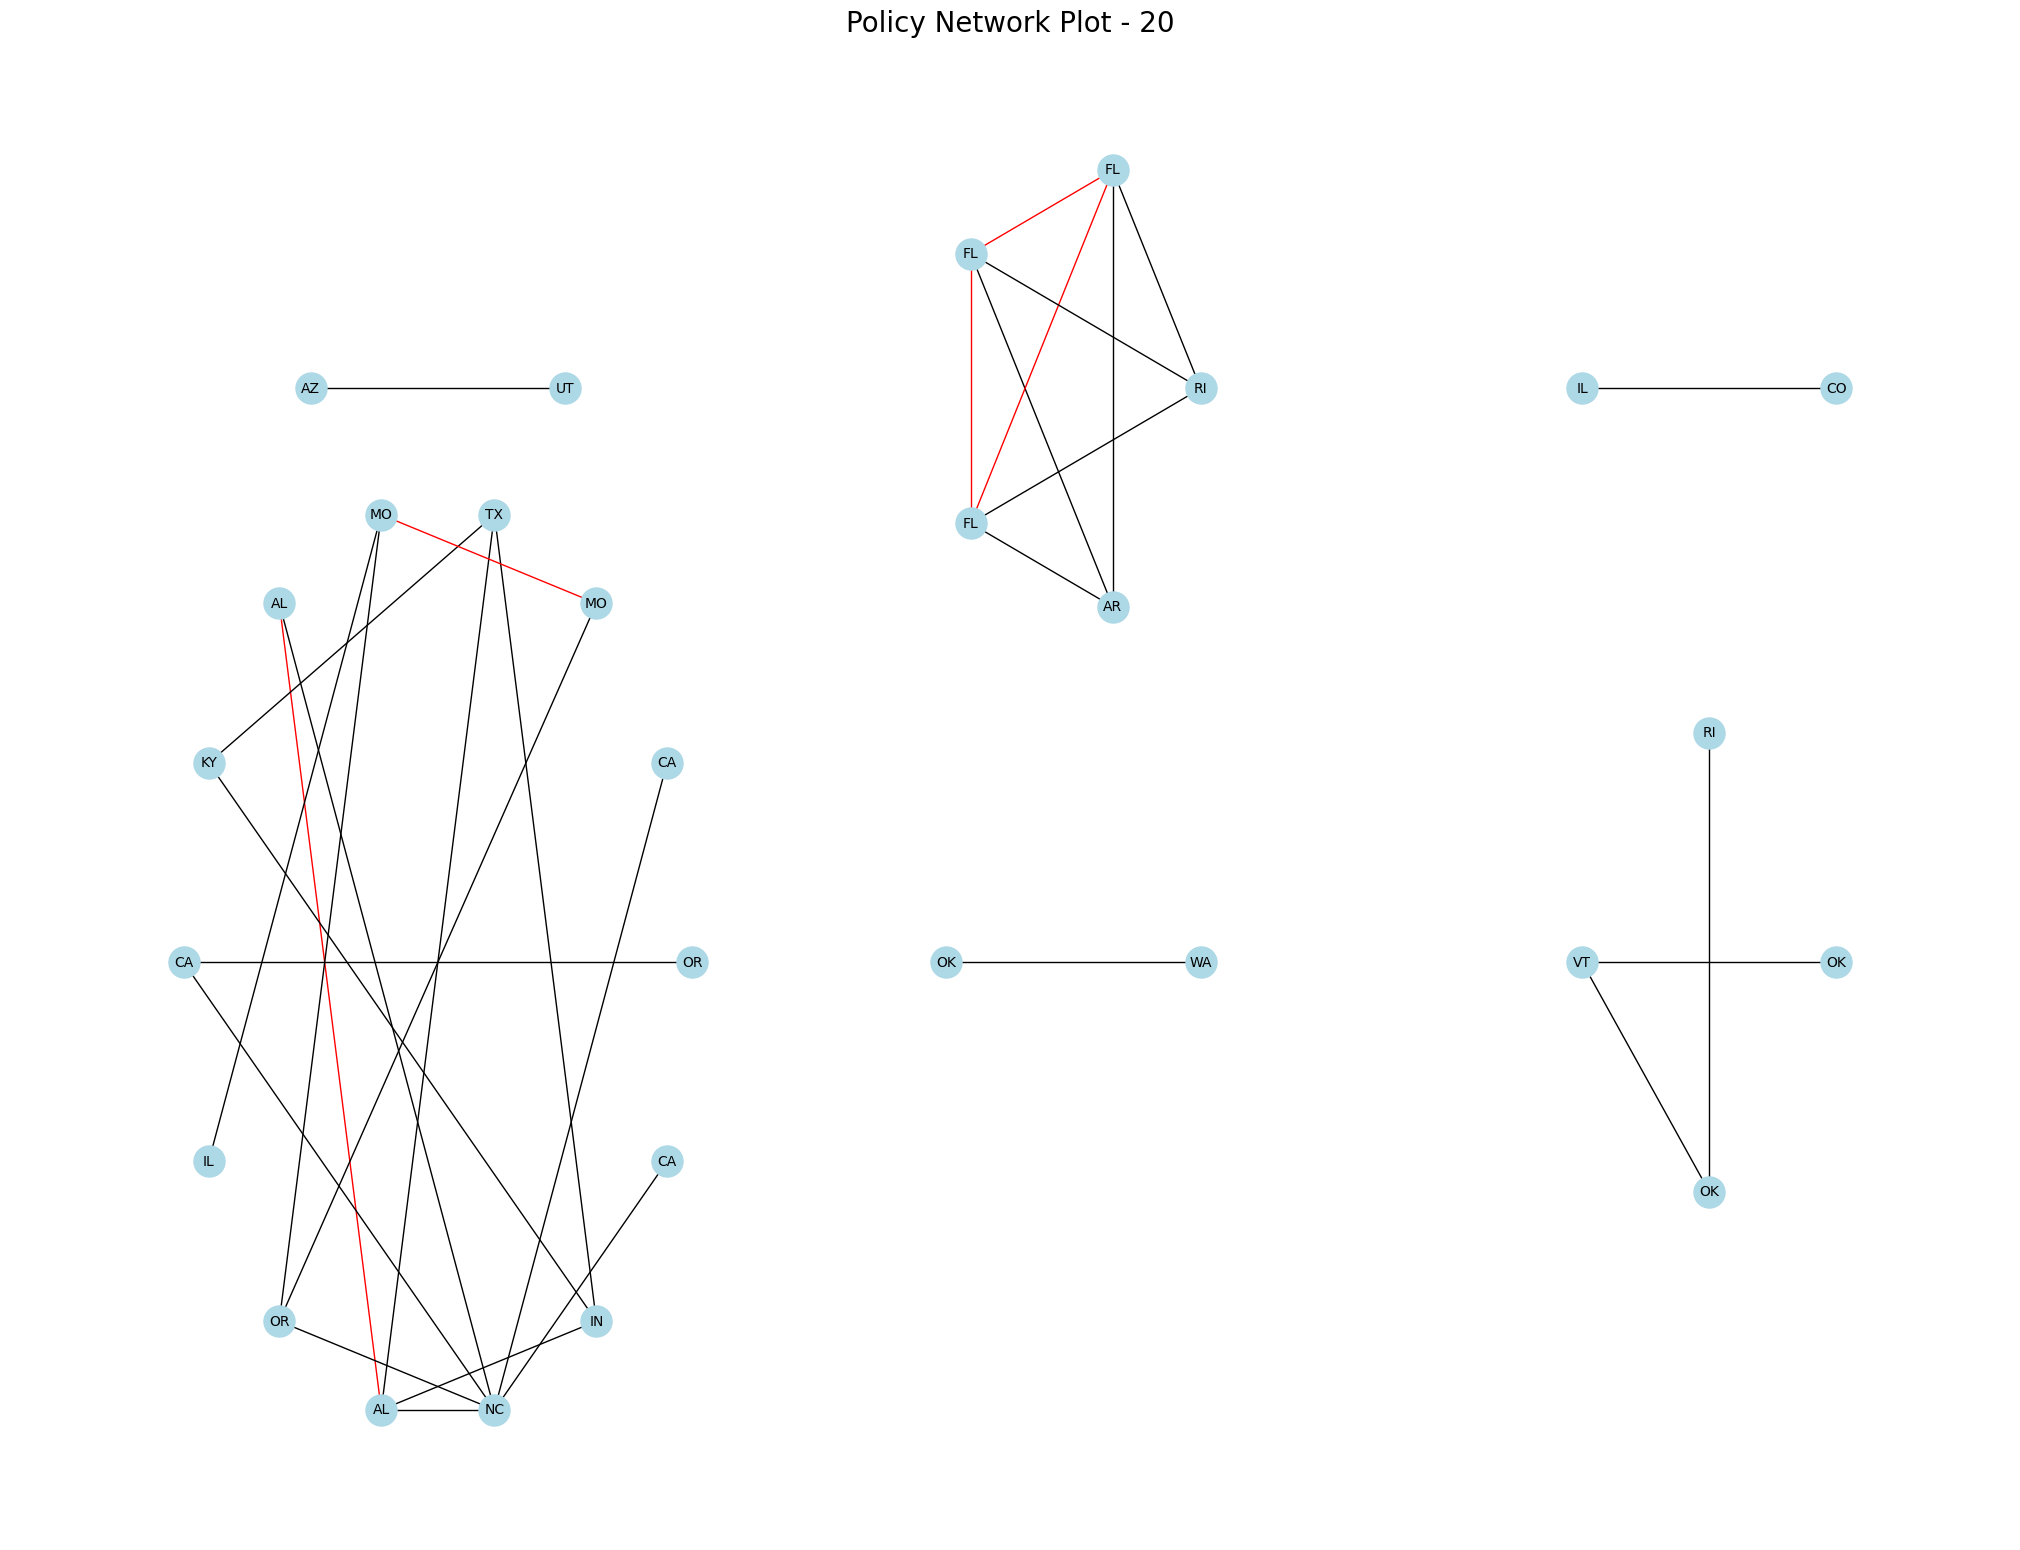

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Load the metadata for mapping and relationships
metadata_policy = pd.read_csv('/content/drive/MyDrive/Policy_comparison/Policy Metadata - Sheet1.csv')
state_abbreviations = pd.read_csv('/content/drive/MyDrive/Policy_comparison/Copy of Policy Metadata - Sheet1.csv')

# Create a mapping from ID to state abbreviation
id_to_state = state_abbreviations.set_index('ID')['Unnamed: 1'].to_dict()

# Initial network graph setup
G = nx.Graph()

# List of pairs from data
pairs = [
    ('2.txt', '124.txt'), ('45.txt', '40.txt'), ('10.txt', '129.txt'),
    ('93.txt', '145.txt'), ('72.txt', '98.txt'), ('8.txt', '25a.txt'),
    ('94.txt', '142.txt'), ('8.txt', '25b.txt'), ('2.txt', '40.txt'),
    ('25.txt', '106.txt'), ('124.txt', '40.txt'), ('8.txt', '25.txt'),
    ('142.txt', '92.txt'), ('106.txt', '25b.txt'), ('104.txt', '92.txt'),
    ('106.txt', '25a.txt'), ('45.txt', '124.txt'), ('72.txt', '1.txt'),
    ('72.txt', '2.txt'), ('98.txt', '67.txt'), ('20.txt', '31.txt'),
    ('19.txt', '100.txt'), ('98.txt', '66.txt'), ('19.txt', '72.txt'),
    ('32.txt', '67.txt'), ('16.txt', '72.txt'), ('17.txt', '72.txt')
]

def prepare_data(df):
    # Extract base ID as a string without suffix for matching
    df['Base ID'] = df['ID'].astype(str).str.extract(r'(\d+)')
    # Map each base ID to its state (assuming no NA in base IDs)
    state_map = df.dropna(subset=['State / Jurisdiction']).set_index('Base ID')['State / Jurisdiction'].to_dict()
    # Fill missing 'State / Jurisdiction' using the state map based on Base ID
    df['State / Jurisdiction'] = df['State / Jurisdiction'].fillna(df['Base ID'].map(state_map))
    return df

# Prepare and clean data
metadata_policy = prepare_data(metadata_policy)

# Add edges based on pairs
for pair in pairs:
    G.add_edge(pair[0], pair[1])

def get_sav_edges(policy_data):
    sav_edges = []
    # Group data by State and then process each group
    grouped_by_state = policy_data.groupby('State / Jurisdiction')
    for state, data in grouped_by_state:
        # Extract numeric and alphabetic parts of 'Sav #'
        data['Numeric Base'] = data['Sav #'].str.extract(r'(\d+)')
        data['Alphabetic Suffix'] = data['Sav #'].str.extract(r'([a-zA-Z]+)')
        # Filter out rows without alphabetic suffixes
        filtered_data = data.dropna(subset=['Numeric Base', 'Alphabetic Suffix'])
        # Group by numeric base within the same state
        grouped_by_base = filtered_data.groupby('Numeric Base')
        for base, base_data in grouped_by_base:
            files = base_data['ID'].astype(str).apply(lambda x: x + '.txt').tolist()
            if len(files) > 1:
                # Connect every file to every other file within the same base group
                for i in range(len(files)):
                    for j in range(i + 1, len(files)):
                        sav_edges.append((files[i], files[j]))
    return sav_edges


red_edges = get_sav_edges(metadata_policy)
red_edges = [(u, v) for u, v in red_edges if u in G.nodes and v in G.nodes]


for u, v in red_edges:
    G.add_edge(u, v, color='red')

labels = {node: id_to_state.get(node.split('.')[0], 'Unknown') for node in G.nodes()}

for pair in pairs:
    G.add_edge(pair[0], pair[1])

# Manual positioning of components
component_positions = {
    1: np.array([0, 0]),
    2: np.array([0, 5]),
    3: np.array([10, 0]),
    4: np.array([10, 5]),
    5: np.array([20, 0]),
    6: np.array([20, 5])
}

components = {
    1: {'124.txt', '19.txt', '2.txt', '32.txt', '45.txt', '100.txt', '16.txt', '17.txt', '40.txt', '66.txt', '98.txt', '72.txt', '1.txt', '67.txt'},
    2: {'10.txt', '129.txt'},
    3: {'145.txt', '93.txt'},
    4: {'25b.txt', '25a.txt', '106.txt', '25.txt', '8.txt'},
    5: {'94.txt', '92.txt', '142.txt', '104.txt'},
    6: {'20.txt', '31.txt'}
}

# Define larger radius for the larger groups
radii = {1: 4, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2}

# Set initial positions
pos = {}
for component_id, nodes in components.items():
    center = component_positions[component_id]
    angle = 0
    radius = radii[component_id]
    for node in nodes:
        pos[node] = center + np.array([radius * np.cos(angle), radius * np.sin(angle)])
        angle += 2 * np.pi / len(nodes)

# Use these positions as starting points for spring layout
pos = nx.spring_layout(G, pos=pos, fixed=pos.keys(), iterations=500, k=0.5)

# Visualization
plt.figure(figsize=(20, 15))
edge_colors = [G[u][v]['color'] if 'color' in G[u][v] else 'black' for u, v in G.edges()]
nx.draw(G, pos, labels=labels, node_color='lightblue', edge_color=edge_colors, node_size=500, font_size=10, with_labels=True)
plt.title('Policy Network Plot - 20', fontsize=20)
plt.show()



Top 40

In [ ]:
def ensemble_models(preprocessed_texts, file_to_state, n, top = True):
    top_pairs = defaultdict(lambda: {'count': 0, 'models': []})
    file_names = list(file_to_state.keys())

    model_functions = [model_1, model_2, model_3, model_4, model_5, model_6]
    model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6']

    for model_func, model_name in zip(model_functions, model_names):
        top_indices = model_func(preprocessed_texts, n)
        for (i, j), _ in top_indices:
            filenames = (file_names[i], file_names[j])
            top_pairs[filenames]['count'] += 1
            top_pairs[filenames]['models'].append(model_name)
    common_pairs_with_counts = [
        (pair, info['count'], info['models'])
        for pair, info in top_pairs.items()
        if info['count'] >= 2
    ]

    return common_pairs_with_counts

top_pairs_with_counts = ensemble_models(preprocessed_texts, file_to_state, 40, top = True)
top_pairs_with_counts_sorted = sorted(top_pairs_with_counts, key=lambda x: x[1], reverse=True)

for pair, count, models in top_pairs_with_counts_sorted:
    models_str = ', '.join(models)
    print(f"{pair} occur {count} times: {models_str}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


('45.txt', '40.txt') occur 5 times: Model 1, Model 3, Model 4, Model 5, Model 6
('2.txt', '124.txt') occur 4 times: Model 1, Model 2, Model 4, Model 6
('93.txt', '145.txt') occur 4 times: Model 3, Model 4, Model 5, Model 6
('98.txt', '66.txt') occur 4 times: Model 3, Model 4, Model 5, Model 6
('10.txt', '129.txt') occur 3 times: Model 3, Model 4, Model 6
('98.txt', '67.txt') occur 3 times: Model 3, Model 4, Model 5
('72.txt', '98.txt') occur 3 times: Model 3, Model 5, Model 6
('68.txt', '98.txt') occur 3 times: Model 3, Model 4, Model 5
('16.txt', '72.txt') occur 3 times: Model 4, Model 5, Model 6
('17.txt', '72.txt') occur 3 times: Model 4, Model 5, Model 6
('8.txt', '25a.txt') occur 2 times: Model 1, Model 2
('94.txt', '142.txt') occur 2 times: Model 1, Model 2
('8.txt', '25b.txt') occur 2 times: Model 1, Model 2
('2.txt', '40.txt') occur 2 times: Model 1, Model 2
('25.txt', '106.txt') occur 2 times: Model 1, Model 2
('124.txt', '40.txt') occur 2 times: Model 1, Model 2
('15.txt', '1

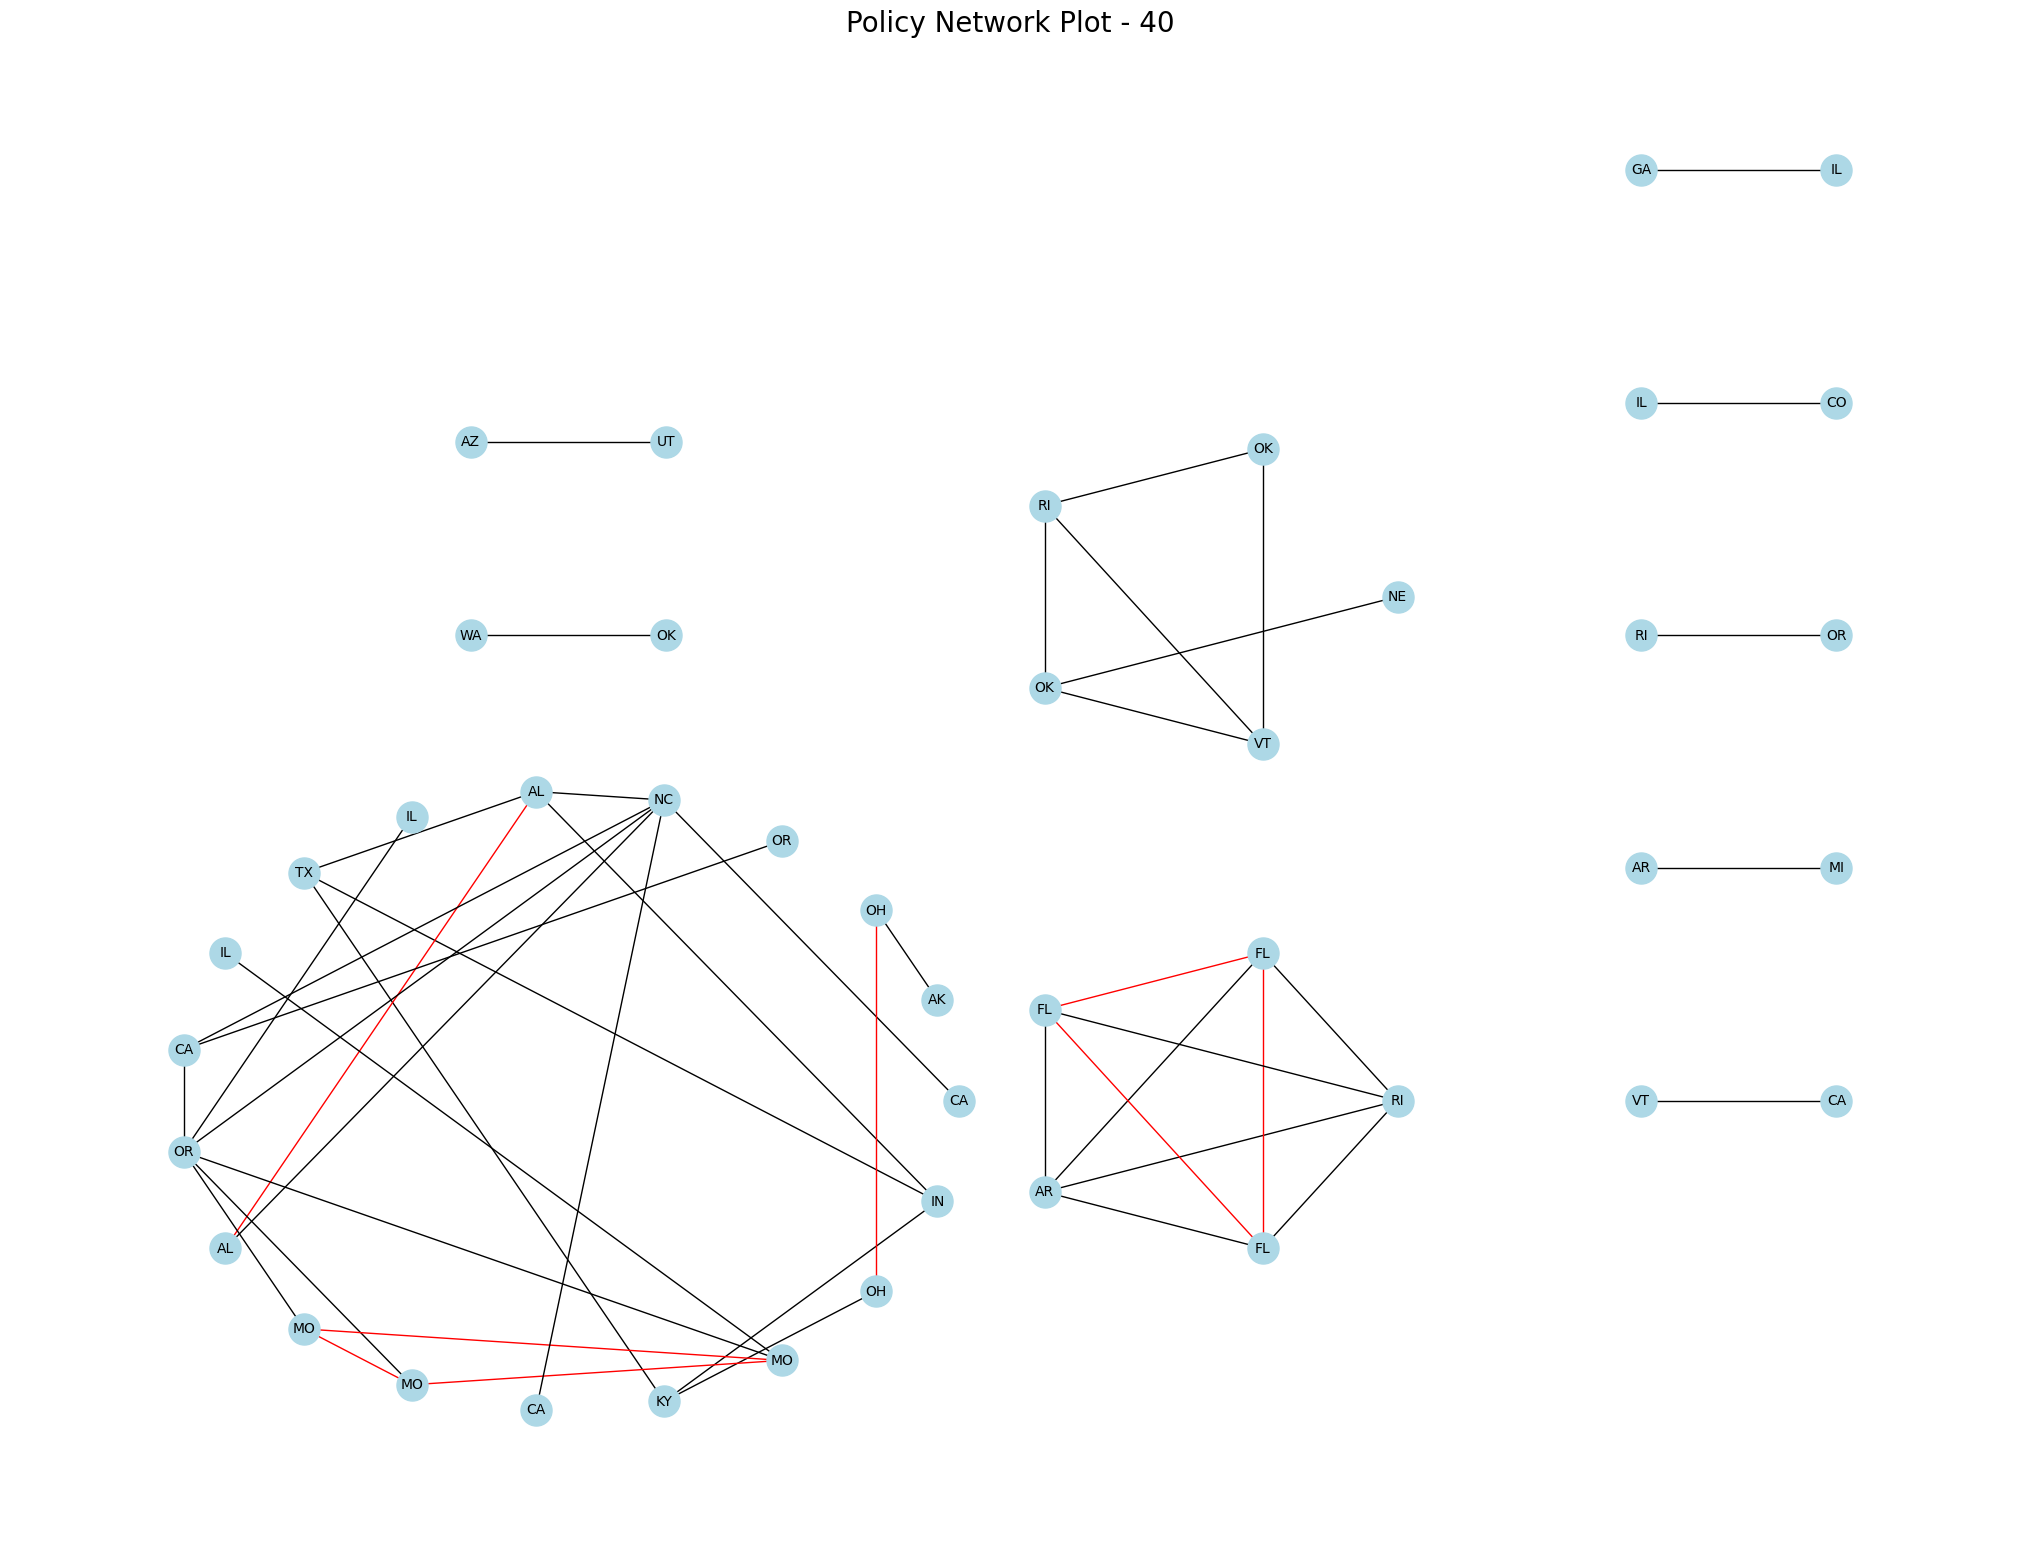

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Load the metadata for mapping and relationships
metadata_policy = pd.read_csv('/content/drive/MyDrive/Policy_comparison/Policy Metadata - Sheet1.csv')
state_abbreviations = pd.read_csv('/content/drive/MyDrive/Policy_comparison/Copy of Policy Metadata - Sheet1.csv')

# Create a mapping from ID to state abbreviation
id_to_state = state_abbreviations.set_index('ID')['Unnamed: 1'].to_dict()

# Initial network graph setup
G = nx.Graph()

# List of pairs from your provided data
pairs = [
    ('45.txt', '40.txt'), ('2.txt', '124.txt'), ('93.txt', '145.txt'),
    ('98.txt', '66.txt'), ('10.txt', '129.txt'), ('98.txt', '67.txt'),
    ('72.txt', '98.txt'), ('68.txt', '98.txt'), ('16.txt', '72.txt'),
    ('17.txt', '72.txt'), ('8.txt', '25a.txt'), ('94.txt', '142.txt'),
    ('8.txt', '25b.txt'), ('2.txt', '40.txt'), ('25.txt', '106.txt'),
    ('124.txt', '40.txt'), ('15.txt', '141.txt'), ('8.txt', '25.txt'),
    ('8.txt', '106.txt'), ('142.txt', '92.txt'), ('106.txt', '25b.txt'),
    ('104.txt', '92.txt'), ('106.txt', '25a.txt'), ('45.txt', '124.txt'),
    ('94.txt', '104.txt'), ('9.txt', '63.txt'), ('104.txt', '142.txt'),
    ('75.txt', '94.txt'), ('96.txt', '102.txt'), ('45.txt', '91.txt'),
    ('72.txt', '1.txt'), ('72.txt', '2.txt'), ('98.txt', '36.txt'),
    ('4.txt', '90.txt'), ('20.txt', '31.txt'), ('19.txt', '100.txt'),
    ('19.txt', '72.txt'), ('32.txt', '67.txt'), ('19.txt', '98.txt'),
    ('33.txt', '28.txt')
]

def prepare_data(df):
    # Extract base ID as a string without suffix for matching
    df['Base ID'] = df['ID'].astype(str).str.extract(r'(\d+)')
    # Map each base ID to its state (assuming no NA in base IDs)
    state_map = df.dropna(subset=['State / Jurisdiction']).set_index('Base ID')['State / Jurisdiction'].to_dict()
    # Fill missing 'State / Jurisdiction' using the state map based on Base ID
    df['State / Jurisdiction'] = df['State / Jurisdiction'].fillna(df['Base ID'].map(state_map))
    return df

# Prepare and clean data
metadata_policy = prepare_data(metadata_policy)

# Add edges based on pairs
for pair in pairs:
    G.add_edge(pair[0], pair[1])

def get_sav_edges(policy_data):
    sav_edges = []
    # Group data by State and then process each group
    grouped_by_state = policy_data.groupby('State / Jurisdiction')
    for state, data in grouped_by_state:
        # Extract numeric and alphabetic parts of 'Sav #'
        data['Numeric Base'] = data['Sav #'].str.extract(r'(\d+)')
        data['Alphabetic Suffix'] = data['Sav #'].str.extract(r'([a-zA-Z]+)')
        # Filter out rows without alphabetic suffixes
        filtered_data = data.dropna(subset=['Numeric Base', 'Alphabetic Suffix'])
        # Group by numeric base within the same state
        grouped_by_base = filtered_data.groupby('Numeric Base')
        for base, base_data in grouped_by_base:
            files = base_data['ID'].astype(str).apply(lambda x: x + '.txt').tolist()
            if len(files) > 1:
                # Connect every file to every other file within the same base group
                for i in range(len(files)):
                    for j in range(i + 1, len(files)):
                        sav_edges.append((files[i], files[j]))
    return sav_edges

# Apply the function to get the red edges
red_edges = get_sav_edges(metadata_policy)
red_edges = [(u, v) for u, v in red_edges if u in G.nodes and v in G.nodes]

# Add these red edges to the graph with the color 'red'
for u, v in red_edges:
    G.add_edge(u, v, color='red')

labels = {node: id_to_state.get(node.split('.')[0], 'Unknown') for node in G.nodes()}

for pair in pairs:
    G.add_edge(pair[0], pair[1])

# Manual positioning of components
component_positions = {
    1: np.array([0, 0]),
    2: np.array([0, 12]),
    3: np.array([0, 17]),
    4: np.array([13, 0]),
    5: np.array([13, 13]),
    6: np.array([24, 0]),
    7: np.array([24, 6]),
    8: np.array([24, 12]),
    9: np.array([24, 18]),
    10: np.array([24, 24])
}

components = { 1: {'45.txt', '1.txt', '90.txt', '2.txt', '36.txt', '68.txt', '124.txt', '4.txt', '100.txt', '40.txt', '66.txt', '32.txt', '19.txt', '16.txt', '17.txt', '91.txt', '98.txt', '72.txt', '67.txt'},
2: {'145.txt', '93.txt'},
3: {'10.txt', '129.txt'},
4: {'25b.txt', '25a.txt', '106.txt', '25.txt', '8.txt'},
 5: {'92.txt', '142.txt', '75.txt', '94.txt', '104.txt'},
 6: {'15.txt', '141.txt'},
 7: {'63.txt', '9.txt'},
 8: {'102.txt', '96.txt'},
 9: {'20.txt', '31.txt'},
 10: {'33.txt', '28.txt'}
}

radii = {1: 8, 2: 2, 3: 2, 4: 4, 5: 4, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2}

# Set initial positions
pos = {}
for component_id, nodes in components.items():
    center = component_positions[component_id]
    angle = 0
    radius = radii[component_id]
    for node in nodes:
        pos[node] = center + np.array([radius * np.cos(angle), radius * np.sin(angle)])
        angle += 2 * np.pi / len(nodes)

# Use these positions as starting points for spring layout
pos = nx.spring_layout(G, pos=pos, fixed=pos.keys(), iterations=500, k=0.5)

# Visualization
plt.figure(figsize=(20, 15))
edge_colors = [G[u][v]['color'] if 'color' in G[u][v] else 'black' for u, v in G.edges()]
nx.draw(G, pos, labels=labels, node_color='lightblue', edge_color=edge_colors, node_size=500, font_size=10, with_labels=True)
plt.title('Policy Network Plot - 40', fontsize=20)
plt.show()



Top 50

In [ ]:
def ensemble_models(preprocessed_texts, file_to_state, n, top = True):
    top_pairs = defaultdict(lambda: {'count': 0, 'models': []})
    file_names = list(file_to_state.keys())

    model_functions = [model_1, model_2, model_3, model_4, model_5, model_6]
    model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6']

    for model_func, model_name in zip(model_functions, model_names):
        top_indices = model_func(preprocessed_texts, n)
        for (i, j), _ in top_indices:
            filenames = (file_names[i], file_names[j])
            top_pairs[filenames]['count'] += 1
            top_pairs[filenames]['models'].append(model_name)
    common_pairs_with_counts = [
        (pair, info['count'], info['models'])
        for pair, info in top_pairs.items()
        if info['count'] >= 2
    ]

    return common_pairs_with_counts

top_pairs_with_counts = ensemble_models(preprocessed_texts, file_to_state, 50, top = True)
top_pairs_with_counts_sorted = sorted(top_pairs_with_counts, key=lambda x: x[1], reverse=True)

for pair, count, models in top_pairs_with_counts_sorted:
    models_str = ', '.join(models)
    print(f"{pair} occur {count} times: {models_str}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

('45.txt', '40.txt') occur 6 times: Model 1, Model 2, Model 3, Model 4, Model 5, Model 6
('2.txt', '124.txt') occur 4 times: Model 1, Model 2, Model 4, Model 6
('93.txt', '145.txt') occur 4 times: Model 3, Model 4, Model 5, Model 6
('98.txt', '66.txt') occur 4 times: Model 3, Model 4, Model 5, Model 6
('2.txt', '40.txt') occur 3 times: Model 1, Model 2, Model 6
('124.txt', '40.txt') occur 3 times: Model 1, Model 2, Model 3
('45.txt', '124.txt') occur 3 times: Model 1, Model 2, Model 3
('11.txt', '144.txt') occur 3 times: Model 1, Model 2, Model 6
('10.txt', '129.txt') occur 3 times: Model 3, Model 4, Model 6
('98.txt', '67.txt') occur 3 times: Model 3, Model 4, Model 5
('72.txt', '98.txt') occur 3 times: Model 3, Model 5, Model 6
('68.txt', '98.txt') occur 3 times: Model 3, Model 4, Model 5
('16.txt', '72.txt') occur 3 times: Model 4, Model 5, Model 6
('17.txt', '72.txt') occur 3 times: Model 4, Model 5, Model 6
('8.txt', '25a.txt') occur 2 times: Model 1, Model 2
('94.txt', '142.txt')

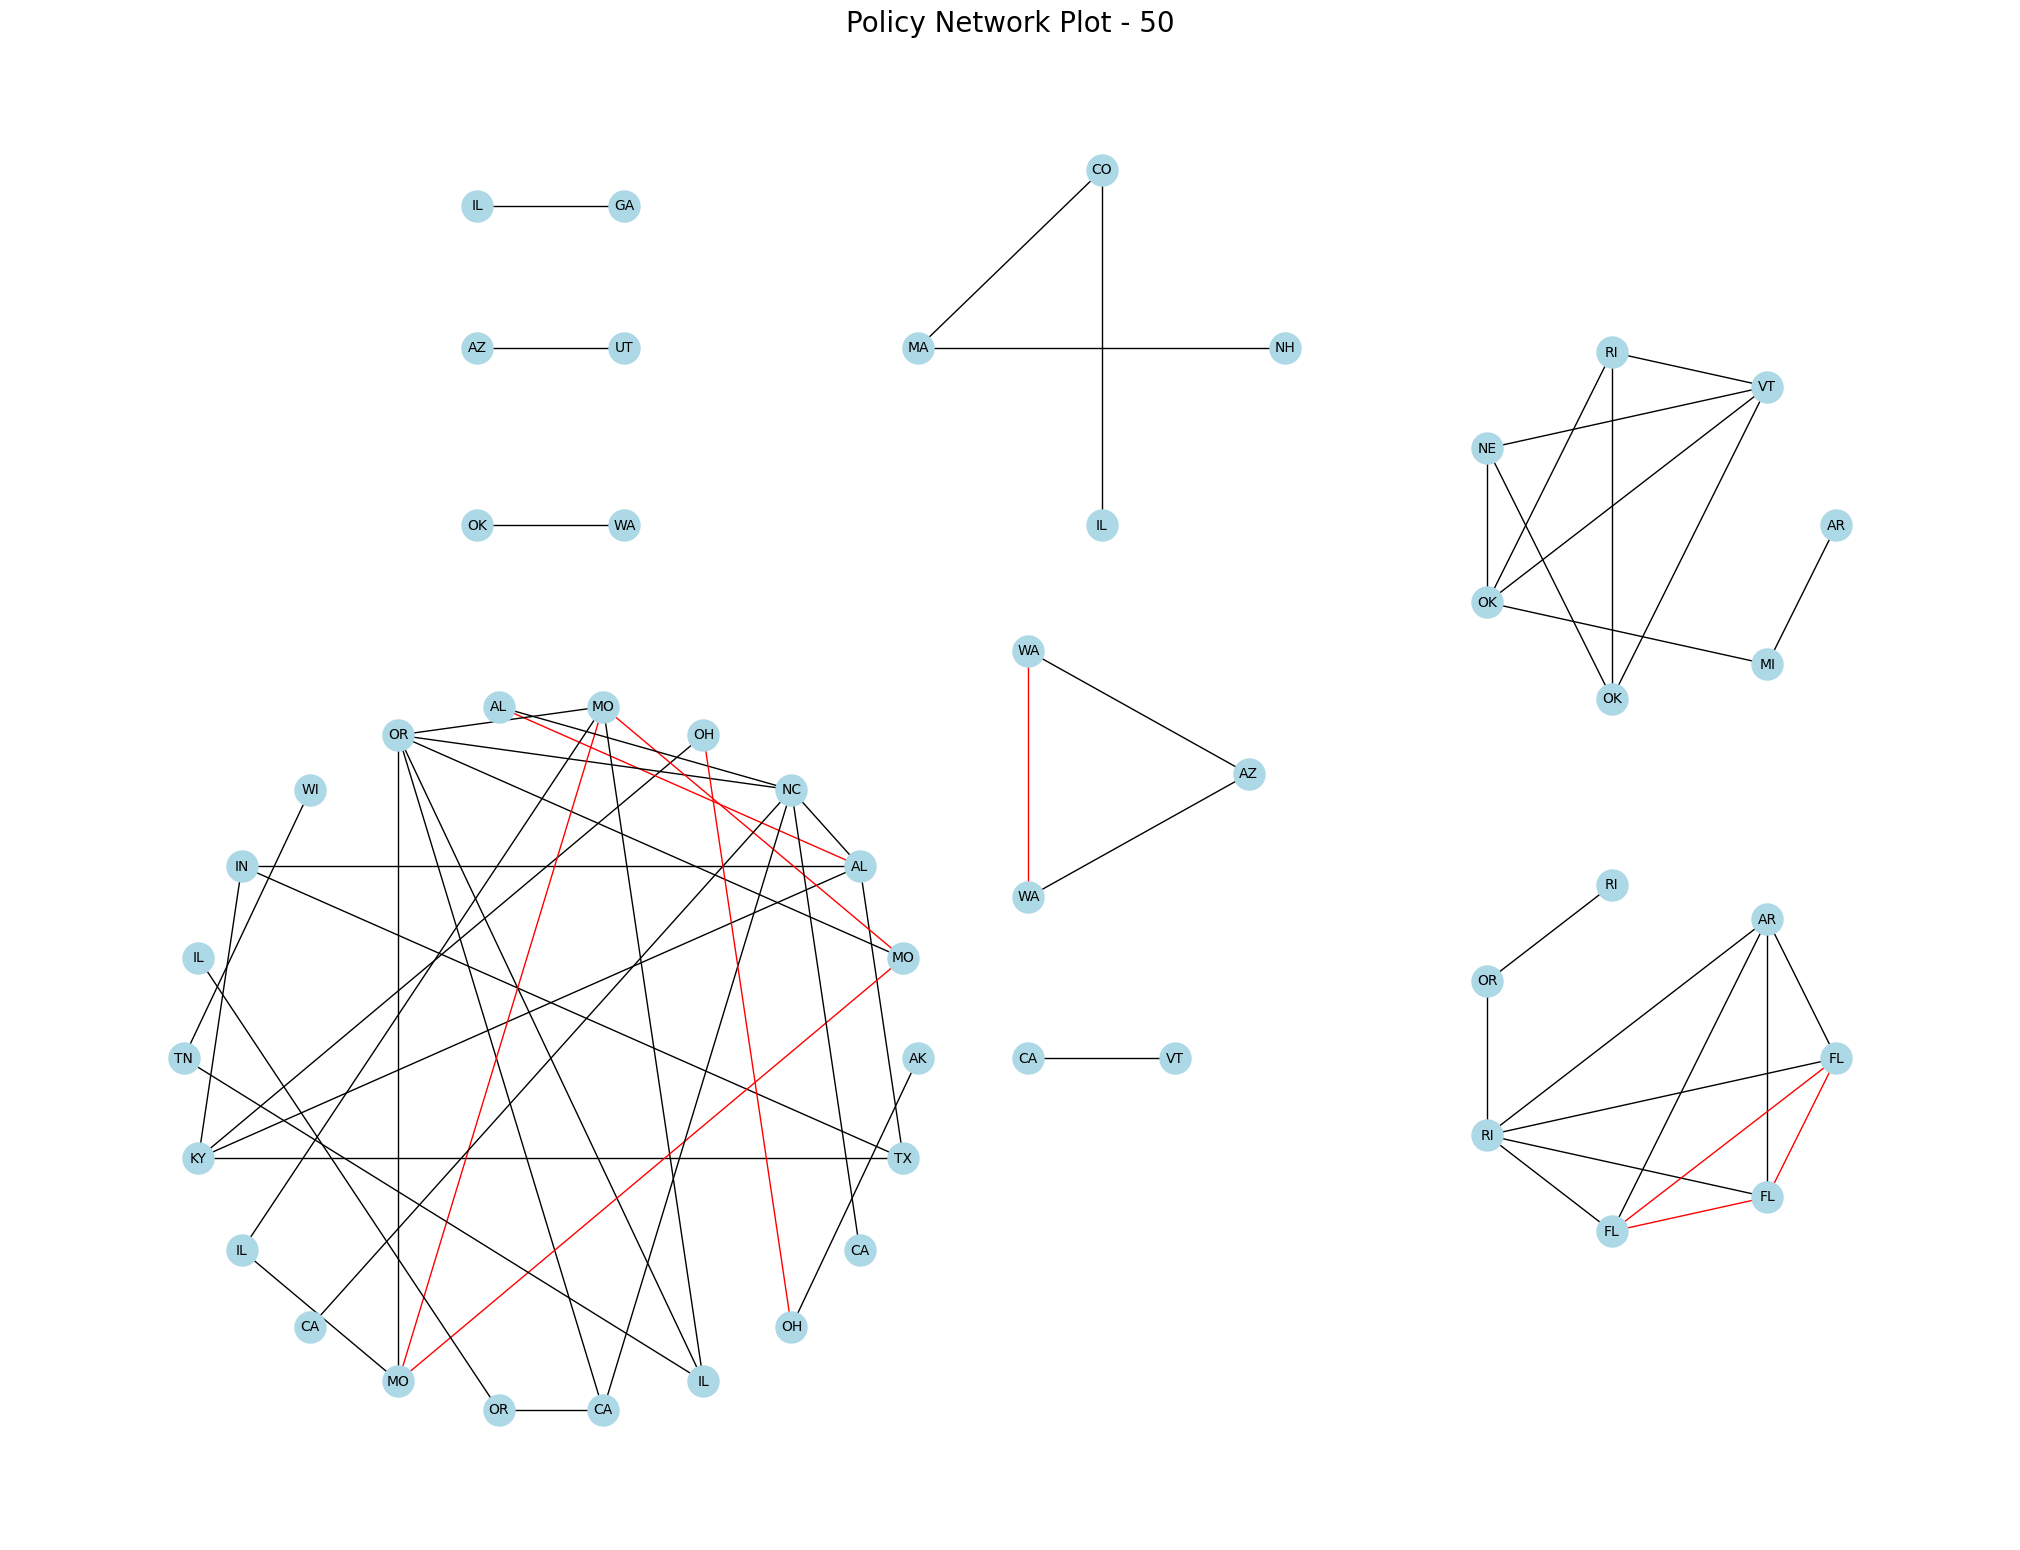

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Load the metadata for mapping and relationships

metadata_policy = pd.read_csv('/content/drive/MyDrive/Policy_comparison/Policy Metadata - Sheet1.csv')
state_abbreviations = pd.read_csv('/content/drive/MyDrive/Policy_comparison/Copy of Policy Metadata - Sheet1.csv')

# Create a mapping from ID to state abbreviation
id_to_state = state_abbreviations.set_index('ID')['Unnamed: 1'].to_dict()

# Initial network graph setup
G = nx.Graph()

# List of pairs from your provided data
pairs = [
    ('45.txt', '40.txt'),
    ('2.txt', '124.txt'),
    ('93.txt', '145.txt'),
    ('98.txt', '66.txt'),
    ('2.txt', '40.txt'),
    ('124.txt', '40.txt'),
    ('45.txt', '124.txt'),
    ('11.txt', '144.txt'),
    ('10.txt', '129.txt'),
    ('98.txt', '67.txt'),
    ('72.txt', '98.txt'),
    ('68.txt', '98.txt'),
    ('16.txt', '72.txt'),
    ('17.txt', '72.txt'),
    ('8.txt', '25a.txt'),
    ('94.txt', '142.txt'),
    ('8.txt', '25b.txt'),
    ('25.txt', '106.txt'),
    ('15.txt', '141.txt'),
    ('8.txt', '25.txt'),
    ('8.txt', '106.txt'),
    ('142.txt', '92.txt'),
    ('106.txt', '25b.txt'),
    ('104.txt', '92.txt'),
    ('106.txt', '25a.txt'),
    ('45.txt', '2.txt'),
    ('94.txt', '104.txt'),
    ('9.txt', '63.txt'),
    ('104.txt', '142.txt'),
    ('75.txt', '94.txt'),
    ('106.txt', '96.txt'),
    ('96.txt', '102.txt'),
    ('75.txt', '142.txt'),
    ('63.txt', '92.txt'),
    ('75.txt', '92.txt'),
    ('45.txt', '91.txt'),
    ('11.txt', '144a.txt'),
    ('72.txt', '1.txt'),
    ('72.txt', '2.txt'),
    ('98.txt', '36.txt'),
    ('4.txt', '90.txt'),
    ('20.txt', '31.txt'),
    ('19.txt', '100.txt'),
    ('112.txt', '36.txt'),
    ('19.txt', '72.txt'),
    ('32.txt', '67.txt'),
    ('112.txt', '148.txt'),
    ('19.txt', '98.txt'),
    ('100.txt', '35.txt'),
    ('33.txt', '28.txt'),
    ('151.txt', '77.txt'),
    ('36.txt', '66.txt'),
    ('20.txt', '151.txt'),
    ('32.txt', '66.txt')
]


def prepare_data(df):
    # Extract base ID as a string without suffix for matching
    df['Base ID'] = df['ID'].astype(str).str.extract(r'(\d+)')
    # Map each base ID to its state (assuming no NA in base IDs)
    state_map = df.dropna(subset=['State / Jurisdiction']).set_index('Base ID')['State / Jurisdiction'].to_dict()
    # Fill missing 'State / Jurisdiction' using the state map based on Base ID
    df['State / Jurisdiction'] = df['State / Jurisdiction'].fillna(df['Base ID'].map(state_map))
    return df

# Prepare and clean data
metadata_policy = prepare_data(metadata_policy)

# Add edges based on pairs
for pair in pairs:
    G.add_edge(pair[0], pair[1])

def get_sav_edges(policy_data):
    sav_edges = []
    # Group data by State and then process each group
    grouped_by_state = policy_data.groupby('State / Jurisdiction')
    for state, data in grouped_by_state:
        # Extract numeric and alphabetic parts of 'Sav #'
        data['Numeric Base'] = data['Sav #'].str.extract(r'(\d+)')
        data['Alphabetic Suffix'] = data['Sav #'].str.extract(r'([a-zA-Z]+)')
        # Filter out rows without alphabetic suffixes
        filtered_data = data.dropna(subset=['Numeric Base', 'Alphabetic Suffix'])
        # Group by numeric base within the same state
        grouped_by_base = filtered_data.groupby('Numeric Base')
        for base, base_data in grouped_by_base:
            files = base_data['ID'].astype(str).apply(lambda x: x + '.txt').tolist()
            if len(files) > 1:
                # Connect every file to every other file within the same base group
                for i in range(len(files)):
                    for j in range(i + 1, len(files)):
                        sav_edges.append((files[i], files[j]))
    return sav_edges

# Apply the function to get the red edges
red_edges = get_sav_edges(metadata_policy)
red_edges = [(u, v) for u, v in red_edges if u in G.nodes and v in G.nodes]

# Add these red edges to the graph with the color 'red'
for u, v in red_edges:
    G.add_edge(u, v, color='red')

labels = {node: id_to_state.get(node.split('.')[0], 'Unknown') for node in G.nodes()}

for pair in pairs:
    G.add_edge(pair[0], pair[1])

# Manual positioning of components
component_positions = {
    1: np.array([0, 0]),
    2: np.array([0, 15]),
    3: np.array([15, 8]),
    4: np.array([0, 20]),
    5: np.array([30, 0]),
    6: np.array([30, 15]),
    7: np.array([15, 0]),
    8: np.array([15, 20]),
    9: np.array([0, 24])
}

components = { 1: {'68.txt', '36.txt', '4.txt', '2.txt', '45.txt', '35.txt', '40.txt', '16.txt', '100.txt', '67.txt', '1.txt', '32.txt', '72.txt', '17.txt', '148.txt', '124.txt', '19.txt', '98.txt', '91.txt', '112.txt', '66.txt', '90.txt'},
2: {'93.txt', '145.txt'},
3: {'11.txt', '144a.txt', '144.txt'},
4: {'10.txt', '129.txt'},
 5: {'25b.txt', '8.txt', '25a.txt', '25.txt', '106.txt', '102.txt', '96.txt'},
 6: {'94.txt', '142.txt', '9.txt', '92.txt', '63.txt', '75.txt', '104.txt'},
 7: {'141.txt', '15.txt'},
 8: {'20.txt', '77.txt', '151.txt', '31.txt'},
 9: {'28.txt', '33.txt'}
}

radii = {1: 10, 2: 2, 3: 4, 4: 2, 5: 5, 6: 5, 7: 2, 8: 5, 9: 2}

# Set initial positions
pos = {}
for component_id, nodes in components.items():
    center = component_positions[component_id]
    angle = 0
    radius = radii[component_id]
    for node in nodes:
        pos[node] = center + np.array([radius * np.cos(angle), radius * np.sin(angle)])
        angle += 2 * np.pi / len(nodes)

# Use these positions as starting points for spring layout
pos = nx.spring_layout(G, pos=pos, fixed=pos.keys(), iterations=500, k=0.5)

# Visualization
plt.figure(figsize=(20, 15))
edge_colors = [G[u][v]['color'] if 'color' in G[u][v] else 'black' for u, v in G.edges()]
nx.draw(G, pos, labels=labels, node_color='lightblue', edge_color=edge_colors, node_size=500, font_size=10, with_labels=True)
plt.title('Policy Network Plot - 50', fontsize=20)
plt.show()

